# Imports

In [54]:
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold
from sklearn.ensemble import IsolationForest
from sklearn.metrics import confusion_matrix, r2_score
from lightgbm import LGBMRegressor, early_stopping, log_evaluation
from catboost import CatBoostRegressor

rc = {
    "axes.facecolor": "#2E3440",
    "figure.facecolor": "#2E3440",
    "axes.edgecolor": "#4C566A",
    "grid.color": "#4C566A",
    "font.family": "JetBrains Mono",
    "text.color": "#FFFFFF",
    "axes.labelcolor": "#FFFFFF",
    "xtick.color": "#FFFFFF",
    "ytick.color": "#FFFFFF",
    "grid.alpha": 0.4,
    "font.size": 10,
    "axes.labelsize": 10,
    "axes.titlesize": 10,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "legend.fontsize": 10,
    "legend.title_fontsize": 10
}

bp_props = {
    'boxprops':{'facecolor':'#037d97', 'edgecolor':'white'},
    'medianprops':{'color':'white'},
    'whiskerprops':{'color':'white'},
    'capprops':{'color':'white'},
    'flierprops':{'marker':'x', 'markeredgecolor':'white'}
}

sns.set(rc=rc)

In [34]:
train_df = pd.read_csv('train.csv', index_col='id')
test_df = pd.read_csv('test.csv', index_col='id')

# orig_df = pd.read_csv('original.csv')

target_var = 'FloodProbability'
cat_features = ['MonsoonIntensity', 'TopographyDrainage', 'RiverManagement', 
                'Deforestation', 'Urbanization', 'ClimateChange', 'DamsQuality',
                'Siltation', 'AgriculturalPractices', 'Encroachments',
                'IneffectiveDisasterPreparedness', 'DrainageSystems',
                'CoastalVulnerability', 'Landslides', 'Watersheds',
                'DeterioratingInfrastructure', 'PopulationScore', 'WetlandLoss',
                'InadequatePlanning', 'PoliticalFactors']
num_features = []

# Data Description

In [17]:
train_df.head()

,MonsoonIntensity,TopographyDrainage,RiverManagement,Deforestation,Urbanization,ClimateChange,DamsQuality,Siltation,AgriculturalPractices,Encroachments,...,DrainageSystems,CoastalVulnerability,Landslides,Watersheds,DeterioratingInfrastructure,PopulationScore,WetlandLoss,InadequatePlanning,PoliticalFactors,FloodProbability
id,,,,,,,,,,,,,,,,,,,,,
0,5,8,5,8,6,4,4,3,3,4,...,5,3,3,5,4,7,5,7,3,0.445
1,6,7,4,4,8,8,3,5,4,6,...,7,2,0,3,5,3,3,4,3,0.450
2,6,5,6,7,3,7,1,5,4,5,...,7,3,7,5,6,8,2,3,3,0.530
3,3,4,6,5,4,8,4,7,6,8,...,2,4,7,4,4,6,5,7,5,0.535
4,5,3,2,6,4,4,3,3,3,3,...,2,2,6,6,4,1,2,3,5,0.415


## Shape and Columns

In [7]:
print('Train Descriptors')
print(f'Shape: {train_df.shape}')
print(f'Columns : {train_df.columns}')
print('')
print('Test Descriptors')
print(f'Shape: {test_df.shape}')
print(test_df.columns)

Train Descriptors
Shape: (1117957, 21)
Columns : Index(['MonsoonIntensity', 'TopographyDrainage', 'RiverManagement',
       'Deforestation', 'Urbanization', 'ClimateChange', 'DamsQuality',
       'Siltation', 'AgriculturalPractices', 'Encroachments',
       'IneffectiveDisasterPreparedness', 'DrainageSystems',
       'CoastalVulnerability', 'Landslides', 'Watersheds',
       'DeterioratingInfrastructure', 'PopulationScore', 'WetlandLoss',
       'InadequatePlanning', 'PoliticalFactors', 'FloodProbability'],
      dtype='object')

Test Descriptors
Shape: (745305, 20)
Index(['MonsoonIntensity', 'TopographyDrainage', 'RiverManagement',
       'Deforestation', 'Urbanization', 'ClimateChange', 'DamsQuality',
       'Siltation', 'AgriculturalPractices', 'Encroachments',
       'IneffectiveDisasterPreparedness', 'DrainageSystems',
       'CoastalVulnerability', 'Landslides', 'Watersheds',
       'DeterioratingInfrastructure', 'PopulationScore', 'WetlandLoss',
       'InadequatePlanning', 'Pol

## Missing Values

In [8]:
null_values = {'column': [], 'train_null_values': [], 'test_null_values': []}

for col in test_df.columns:
    train_col_null = train_df[col].isna().sum()
    test_col_null = test_df[col].isna().sum()
    
    null_values['column'].append(col)
    null_values['train_null_values'].append(train_col_null)
    null_values['test_null_values'].append(test_col_null)
    
null_values = pd.DataFrame(null_values)
null_values['train_total'] = train_df.shape[0]
null_values['test_total'] = test_df.shape[0]
null_values['train_null_perc'] = null_values['train_null_values'] / null_values['train_total']
null_values['test_null_perc'] = null_values['test_null_values'] / null_values['test_total']
null_values.sort_values(by='train_null_perc', inplace=True, ascending=False)

null_values.style.format({'train_null_perc': '{:.0%}',
                          'test_null_perc': '{:.0%}'})

,column,train_null_values,test_null_values,train_total,test_total,train_null_perc,test_null_perc
0,MonsoonIntensity,0,0,1117957,745305,0%,0%
1,TopographyDrainage,0,0,1117957,745305,0%,0%
18,InadequatePlanning,0,0,1117957,745305,0%,0%
17,WetlandLoss,0,0,1117957,745305,0%,0%
16,PopulationScore,0,0,1117957,745305,0%,0%
15,DeterioratingInfrastructure,0,0,1117957,745305,0%,0%
14,Watersheds,0,0,1117957,745305,0%,0%
13,Landslides,0,0,1117957,745305,0%,0%
12,CoastalVulnerability,0,0,1117957,745305,0%,0%
11,DrainageSystems,0,0,1117957,745305,0%,0%


In [9]:
null_values_per_row = train_df.isna().sum(axis=1)
pd.DataFrame(null_values_per_row.value_counts().sort_index())

,count
0,1117957


In [10]:
missing_values = {'column': [], 'only_in_train': [], 'only_in_test': []}

for col in cat_features:
    train_col_unique = train_df[col].unique()
    test_col_unique = test_df[col].unique()
    
    missing_values['column'].append(col)
    missing_values['only_in_train'].append([f for f in train_col_unique if f not in test_col_unique])
    missing_values['only_in_test'].append([f for f in test_col_unique if f not in train_col_unique])

missing_values = pd.DataFrame(missing_values)
missing_values

,column,only_in_train,only_in_test


## Adversarial Testing

### Train vs Test

In [23]:
df = pd.concat([train_df[num_features].assign(source=0), test_df[num_features].assign(source=1)], ignore_index=True)
origin_var = df['source']
df.drop(columns='source', inplace=True)

n_folds = 5
k_fold = KFold(n_splits=n_folds, random_state=2023, shuffle=True)
train_oof_preds = np.zeros((df.shape[0],))
train_oof_probas = np.zeros((df.shape[0],))

for fold, (train_index, test_index) in enumerate(k_fold.split(df, origin_var)):
    print('-----> Fold {} <-----'.format(fold+1))
    X_train, X_valid = pd.DataFrame(df.iloc[train_index]), pd.DataFrame(df.iloc[test_index])
    y_train, y_valid = origin_var.iloc[train_index], origin_var.iloc[test_index]
    
    model = LGBMClassifier(
        random_state=2023,
        objective='binary',
        metric='auc',
        n_jobs=-1,
        n_estimators=2000,
        verbose=-1,
        max_depth=3,
    )
    model.fit(
        X_train,
        y_train,
        eval_set=[(X_valid, y_valid)],
        callbacks=[
            early_stopping(50, verbose=False),
            log_evaluation(2000),
        ]
    )
    
    oof_preds = model.predict(X_valid)
    oof_probas = model.predict_proba(X_valid)[:,1]
    train_oof_preds[test_index] = oof_preds
    train_oof_probas[test_index] = oof_probas
    print(': AUC ROC = {}'.format(roc_auc_score(y_valid, oof_probas)))

auc_vanilla = roc_auc_score(origin_var, train_oof_probas)
fpr, tpr, _ = roc_curve(origin_var, train_oof_probas)
print("--> Overall results for out of fold predictions")
print(": AUC ROC = {}".format(auc_vanilla))

-----> Fold 1 <-----
: AUC ROC = 0.5007400072325253
-----> Fold 2 <-----
: AUC ROC = 0.5004140843675658
-----> Fold 3 <-----
: AUC ROC = 0.49980024072957246
-----> Fold 4 <-----
: AUC ROC = 0.5027281430952133
-----> Fold 5 <-----
: AUC ROC = 0.5006707068141785
--> Overall results for out of fold predictions
: AUC ROC = 0.5006491850566628


In [ ]:
confusion = confusion_matrix(origin_var, train_oof_preds)

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15,6))

sns.heatmap(confusion, annot=True, fmt=",d", cmap='RdBu', ax=axs[0])
axs[0].set_title("Confusion Matrix (@ 0.5 Probability)")
axs[0].set_ylabel("Actual Class")
axs[0].set_xlabel("Predicted Class")

sns.lineplot(x=[0, 1], y=[0, 1], linestyle="--", label="Indistinguishable Datasets", ax=axs[1])
sns.lineplot(x=fpr, y=tpr, ax=axs[1], label="Adversarial Validation Classifier")
axs[1].set_title("ROC Curve")
axs[1].set_xlabel("False Positive Rate")
axs[1].set_ylabel("True Positive Rate")

plt.show()

### Train/Test Original

In [ ]:
df = pd.concat([train_df[num_features].assign(source=0), test_df[num_features].assign(source=0), orig_df[num_features].assign(source=1)], ignore_index=True)
origin_var = df['source']
df.drop(columns='source', inplace=True)

n_folds = 5
k_fold = KFold(n_splits=n_folds, random_state=2023, shuffle=True)
train_oof_preds = np.zeros((df.shape[0],))
train_oof_probas = np.zeros((df.shape[0],))

for fold, (train_index, test_index) in enumerate(k_fold.split(df, origin_var)):
    print('-----> Fold {} <-----'.format(fold+1))
    X_train, X_valid = pd.DataFrame(df.iloc[train_index]), pd.DataFrame(df.iloc[test_index])
    y_train, y_valid = origin_var.iloc[train_index], origin_var.iloc[test_index]
    
    model = LGBMClassifier(
        random_state=2023,
        objective='binary',
        metric='auc',
        n_jobs=-1,
        n_estimators=2000,
        verbose=-1,
        max_depth=3,
    )
    model.fit(
        X_train,
        y_train,
        eval_set=[(X_valid, y_valid)],
        callbacks=[
            early_stopping(50, verbose=False),
            log_evaluation(2000),
        ]
    )
    
    oof_preds = model.predict(X_valid)
    oof_probas = model.predict_proba(X_valid)[:,1]
    train_oof_preds[test_index] = oof_preds
    train_oof_probas[test_index] = oof_probas
    print(': AUC ROC = {}'.format(roc_auc_score(y_valid, oof_probas)))

auc_vanilla = roc_auc_score(origin_var, train_oof_probas)
fpr, tpr, _ = roc_curve(origin_var, train_oof_probas)
print("--> Overall results for out of fold predictions")
print(": AUC ROC = {}".format(auc_vanilla))

In [ ]:
confusion = confusion_matrix(origin_var, train_oof_preds)

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15,6))

sns.heatmap(confusion, annot=True, fmt=",d", cmap='RdBu', ax=axs[0])
axs[0].set_title("Confusion Matrix (@ 0.5 Probability)")
axs[0].set_ylabel("Actual Class")
axs[0].set_xlabel("Predicted Class")

sns.lineplot(x=[0, 1], y=[0, 1], linestyle="--", label="Indistinguishable Datasets", ax=axs[1])
sns.lineplot(x=fpr, y=tpr, ax=axs[1], label="Adversarial Validation Classifier")
axs[1].set_title("ROC Curve")
axs[1].set_xlabel("False Positive Rate")
axs[1].set_ylabel("True Positive Rate")

plt.show()

# Exploratory Data Analysis

## Variable Distribution

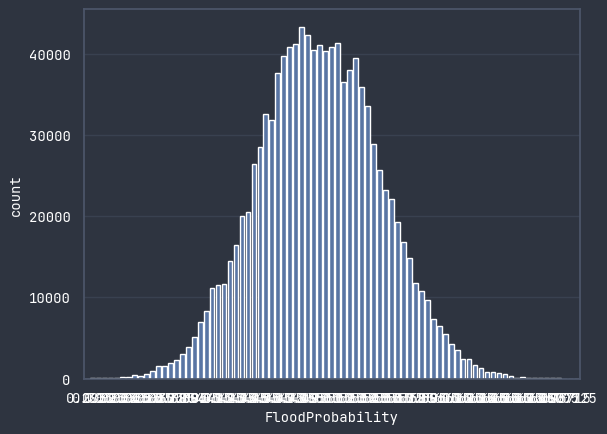

In [27]:
sns.countplot(data=train_df, x=target_var)
plt.show()

## Variable Correlation

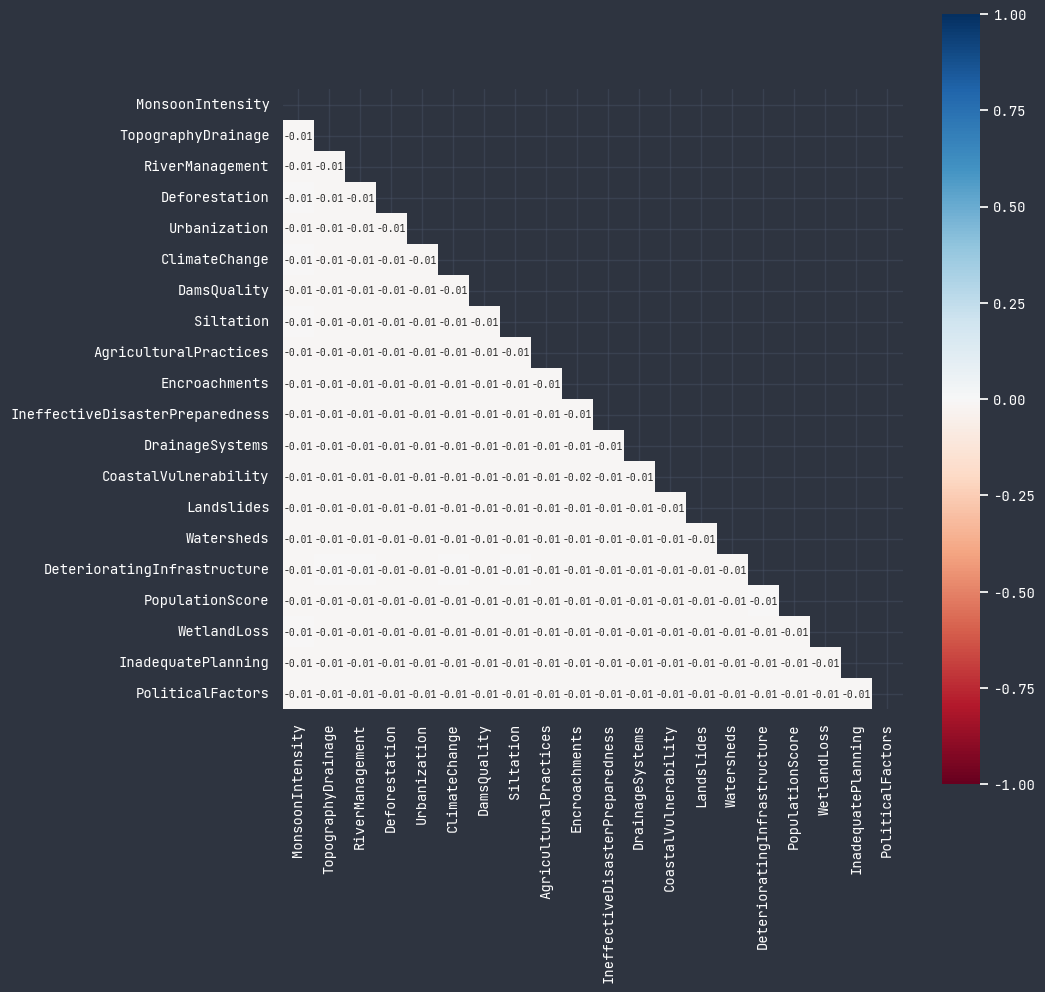

In [35]:
df = pd.concat([train_df[test_df.columns], test_df], ignore_index=True)
df_corr = df.corr(method='pearson')
mask = np.triu(np.ones_like(df_corr, dtype=bool))

plt.figure(figsize=(10, 10))
sns.heatmap(df_corr, mask=mask, annot=True, annot_kws={"size": 7}, fmt='.2f', cmap='RdBu', square=True, vmin=-1, vmax=1)
plt.show()

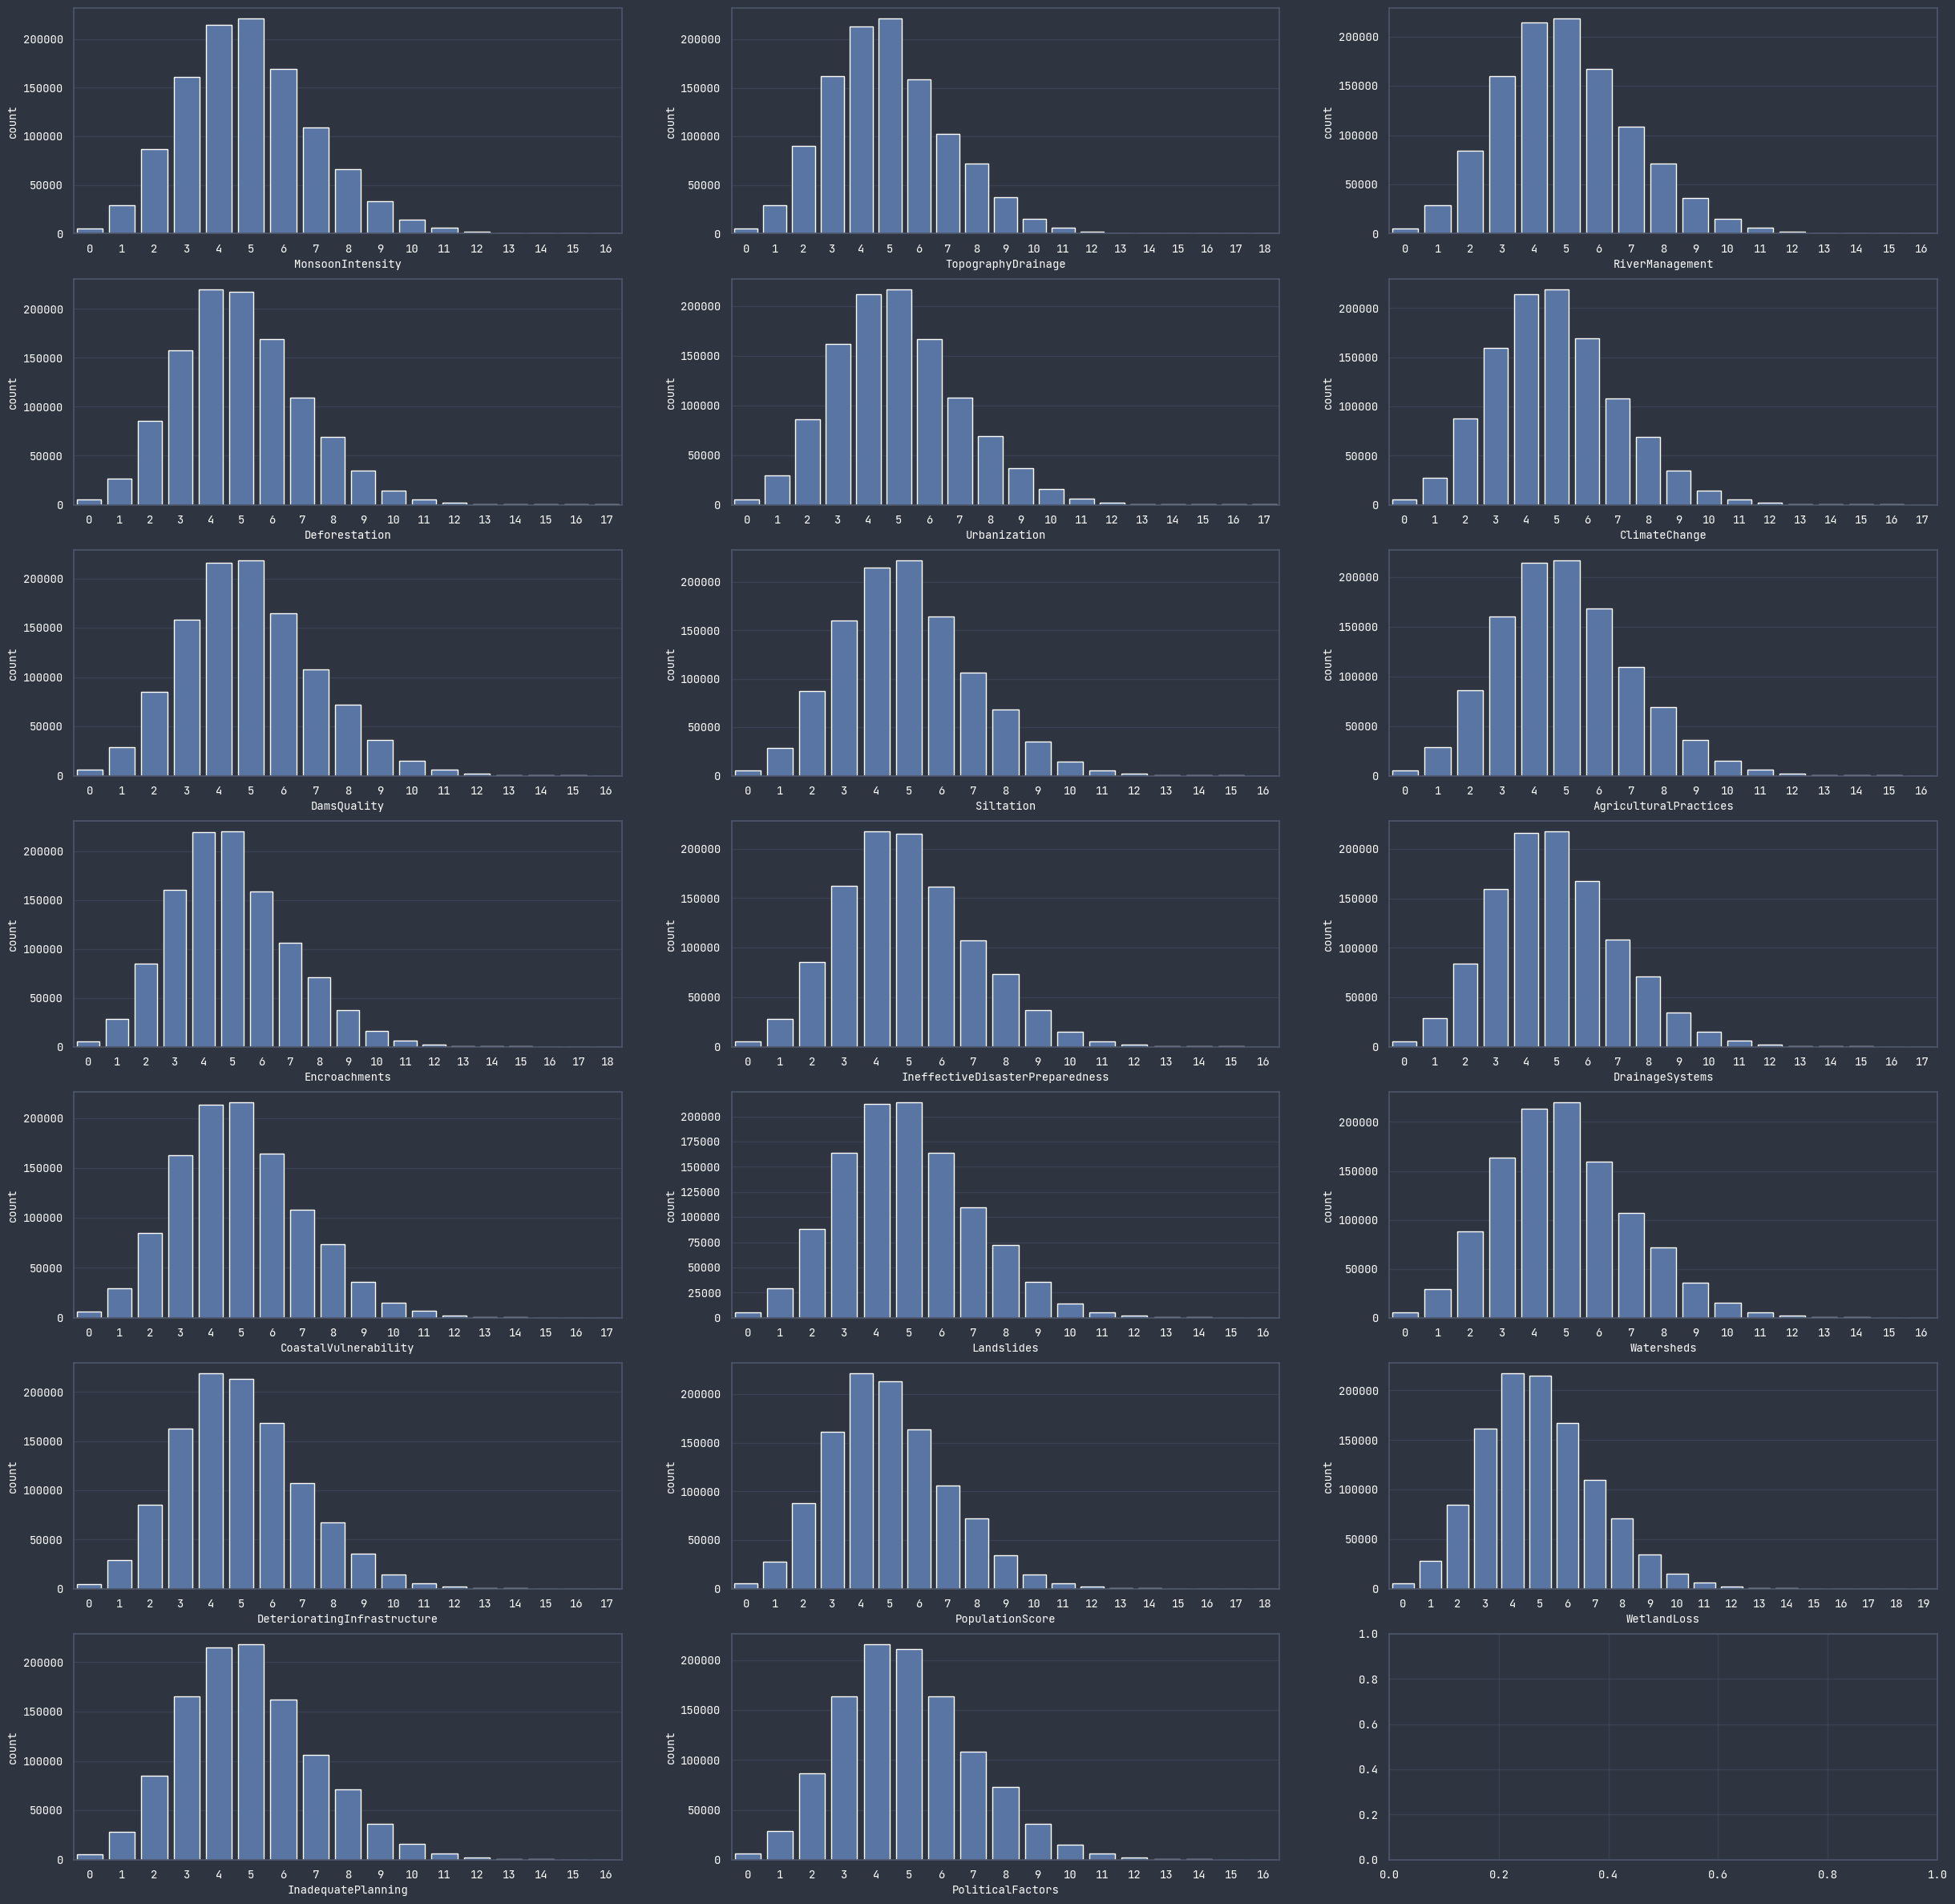

In [36]:
fig, axs = plt.subplots(nrows=len(cat_features)//3 + 1, ncols=3, figsize=(30,30))
axs = axs.flatten()

for i, feat in enumerate(cat_features):
    sns.countplot(data=train_df, x=feat, ax=axs[i])
plt.show()

In [ ]:
df = pd.concat([train_df[num_features].assign(source='train'), test_df[num_features].assign(source='test')], ignore_index=True)

fig, axs = plt.subplots(nrows=len(num_features), ncols=3, figsize=(16, len(num_features) * 3),
                        gridspec_kw= {'hspace': 0.35, 'wspace': 0.3, 'width_ratios': [0.8, 0.2, 0.2]})

for i, feat in enumerate(num_features):
    sns.kdeplot(data=df[[feat, 'source']], x=feat, hue='source', linewidth=2, ax=axs[i, 0])
    axs[i, 0].set_title(feat, fontsize=9)
    axs[i, 0].set(xlabel='', ylabel='')
    
    sns.boxplot(data=df.loc[df['source'] == 'train', [feat]], y=feat, width=0.25, saturation=0.9, linewidth=0.9, fliersize=2.25, ax=axs[i, 1], **bp_props)
    axs[i, 1].set_title('train', fontsize=9)
    axs[i, 1].set(xlabel='', ylabel='')
    
    sns.boxplot(data=df.loc[df['source'] == 'test', [feat]], y=feat, width=0.25, saturation=0.9, linewidth=0.9, fliersize=2.25, color='#037d97', ax=axs[i, 2], **bp_props)
    axs[i, 2].set_title('test', fontsize=9, fontweight='bold')
    axs[i, 2].set(xlabel='', ylabel='')

plt.tight_layout()
plt.show()

# Feature Engineering

## Outliers

### Isolation Forest

In [37]:
iso = IsolationForest(contamination='auto', random_state=2024)
outlier_preds = iso.fit_predict(train_df)
outlier_df = train_df[outlier_preds == -1]

print(f'Number of Outliers: {outlier_df.shape[0]}')
print(f'Percentage of Rows: {round(100 * outlier_df.shape[0] / train_df.shape[0], 2)}%')

Number of Outliers: 44647
Percentage of Rows: 3.99%


# Data Preprocessing

In [38]:
cleaned_train_df = train_df.copy()

combined_df = pd.concat([cleaned_train_df, test_df], ignore_index=True)

cleaned_train_df = combined_df[~combined_df[target_var].isnull()]
cleaned_test_df = combined_df[combined_df[target_var].isnull()].drop(target_var, axis=1)

# Model Evaluation

## Base Model

In [68]:
# Cross Fold Training
n_folds = 5
k_fold = KFold(n_splits=n_folds, random_state=2024, shuffle=True)
train_oof_preds = np.zeros((cleaned_train_df.shape[0],))
oof_metric = []

final_train_df = cleaned_train_df.drop(target_var, axis=1)
target = cleaned_train_df[target_var]

for fold, (train_idx, test_idx) in enumerate(k_fold.split(final_train_df, target)):
    X_train, X_valid = final_train_df.iloc[train_idx], final_train_df.iloc[test_idx]
    y_train, y_valid = target.iloc[train_idx], target.iloc[test_idx]
    
    model = CatBoostRegressor(
        n_estimators=850,
        learning_rate=0.1,
        depth=7,
        colsample_bylevel=0.75,
        random_strength=6.2,
        min_data_in_leaf=90,
        verbose=0
    )
    
    model.fit(
        X_train,
        y_train,
        eval_set=(X_valid, y_valid)
    )
    
    oof_preds = model.predict(X_valid)
    train_oof_preds[test_idx] = oof_preds
    oof_metric.append(r2_score(y_valid, oof_preds))
    
oof_metric = np.array(oof_metric)
overall_metric = r2_score(target, train_oof_preds)
print(f'OOF Scores: {oof_metric}')
print(f'Mean Score: {oof_metric.mean()}')
print(f'Standard Deviation: {oof_metric.std()}')
print('')
print(f'Overall Result: {overall_metric}')
print('')
print(f'{oof_metric:.5f}, {oof_metric.mean():.5f}, {oof_metric.std():.5f}, {overall_metric:.5f}')

OOF Scores: [0.84586979 0.84715703 0.84621608 0.84579108 0.84580059]
Mean Score: 0.8461669139643806
Standard Deviation: 0.0005189344585115062

Overall Result: 0.846168951574028

[0.84586979 0.84715703 0.84621608 0.84579108 0.84580059], 0.84617, 0.00052, 0.84617


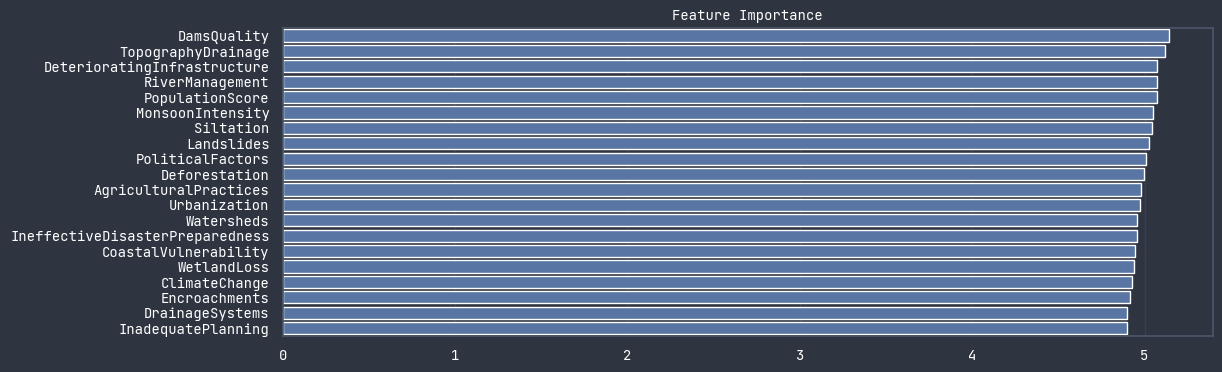

In [71]:
model = CatBoostRegressor(
    n_estimators=850,
    learning_rate=0.1,
    depth=7,
    colsample_bylevel=0.75,
    random_strength=6.2,
    min_data_in_leaf=90,
    verbose=0
)
model.fit(cleaned_train_df.drop(target_var, axis=1), cleaned_train_df[target_var])

feat_imp = pd.DataFrame({
    'feat': cleaned_train_df.drop(target_var, axis=1).columns,
    'importance': model.feature_importances_
})
feat_imp.sort_values(by='importance', ascending=False, inplace=True)

fig = plt.figure(figsize=(12, 0.2*len(feat_imp)))
sns.barplot(data=feat_imp, x='importance', y='feat')
plt.title('Feature Importance')
plt.xlabel('')
plt.ylabel('')
plt.show()

# Submission

In [72]:
test_preds = model.predict(cleaned_test_df)

submission = pd.read_csv('sample_submission.csv')
submission['FloodProbability'] = test_preds
submission.to_csv('submission.csv', index=False)

# Scores Record

In [70]:
scores = {
    'catboost_baseline': [[0.84586979, 0.84715703, 0.84621608, 0.84579108, 0.84580059], 0.84617, 0.00052, 0.84617]
}

scores_df = pd.DataFrame.from_dict(scores, orient='index')
scores_df.columns = ['KFold', 'Mean', 'Std Dev', 'Overall']
scores_df

,KFold,Mean,Std Dev,Overall
catboost_baseline,"[0.84586979, 0.84715703, 0.84621608, 0.8457910...",0.84617,0.00052,0.84617
